# Clasificación de un Compuesto de Medianas Sin Nubes

En el presente notebook se hace la clasificación de un compuesto temporal de medianas extraido del repositorio
de imgágenes del **Cubo de Datos de Imágenes de Satélite de Colombia** en el IDEAM. Un compuesto es un una imagen
libre de nubes contruida por medio de una serie de tomas en el tiempo.

## Referencias

1. http://cdcol.ideam.gov.co/profile/home/

In [1]:
%matplotlib inline

import gdal
import joblib
import os
import pickle
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_bands_positions(path):
    """
    Permite obtener las posiciones y los nombres de las bandas
    a partir de los metadatos de la imágen tif.
    
    [(1, 'green'), (2, 'swir2'), (3, 'nir'), (4, 'blue'), (5, 'red'), (6, 'swir1')]
    """
    ds = gdal.Open(path)
    # Extracción de los metadatos del tif
    metadata = ds.GetMetadata()
    # Extracción de la posición y nombre de las bandas
    positions = [ (int(k[-1]) - 1,v) for k,v in metadata.items() if 'Band_' in k ]
    
    return positions


def load_ideam_geotif(path):
    
    positions = get_bands_positions(path)
    
    data_array = xr.open_rasterio(path)

    # Define las coordenadas de los puntos
    coords = { 
        'x':data_array.x.values, 
        'y':data_array.y.values 
    }
    
    # Define el orden de las dimensiones
    dims = ('y','x')
    
    # Define los metadatos o atributos
    attrs = {
        'crs': data_array.crs,
        'transform': data_array.transform
    }
    
    data = {}
    for band_index, band_name in positions:
        data[band_name] = xr.DataArray(
            data=data_array.values[band_index], 
            coords=coords, 
            dims=dims, 
            name=band_name, 
            attrs=attrs
        )
    
    return data

## Carga de un Archivo tif

La función **open_rasterio** permite cargar los datos deun archivo Geotiff en un arreglo multidimensional. La forma del arreglo depende de cómo haya sido generado el archivo por parte del IDEAM. La información de las bandas debe ser dados en el siguiente orden al modelo de máquinas de aprendizaje. 

* blue
* green
* red
* nir
* swir1
* swir2	

In [3]:
# data = xr.open_rasterio('../../data/prueba/pequena.tif')
# print('Shape:', data.shape)
# data.values

data_array = load_ideam_geotif('../../data/prueba/pequena.tif')

data = np.array([
    data_array['blue'].values,
    data_array['green'].values,
    data_array['red'].values,
    data_array['nir'].values,
    data_array['swir1'].values,
    data_array['swir2'].values,
])

data

array([[[ 377. ,  372. ,  322. , ...,  639.5,  608.5,  593.5],
        [ 443. ,  367.5,  361. , ...,  630.5,  630. ,  559.5],
        [ 406. ,  405. ,  354.5, ...,  600.5,  563.5,  520. ],
        ...,
        [ 227. ,  258. ,  230. , ...,  431. ,  434. ,  731.5],
        [ 214. ,  230. ,  254. , ...,  434.5,  396.5,  406. ],
        [ 202. ,  211. ,  238. , ...,  478. ,  384. ,  412. ]],

       [[ 275.5,  260. ,  218. , ..., 1076. ,  999. ,  950.5],
        [ 325. ,  251. ,  264.5, ..., 1017. , 1002.5,  859. ],
        [ 278. ,  322. ,  262.5, ...,  961. ,  880.5,  801.5],
        ...,
        [ 562. ,  599. ,  553. , ..., 1085.5, 1022. , 1139. ],
        [ 541. ,  564. ,  568. , ...,  879.5,  782. ,  803. ],
        [ 495. ,  509. ,  566. , ...,  973. ,  869. ,  793. ]],

       [[ 215. ,  197. ,  157. , ..., 1364.5, 1287. , 1197.5],
        [ 254. ,  189. ,  196.5, ..., 1316. , 1293. , 1096.5],
        [ 209. ,  244. ,  202. , ..., 1261. , 1144. , 1026. ],
        ...,
        [ 34

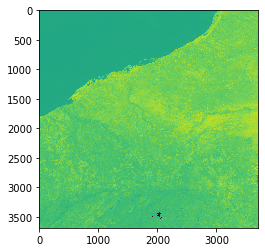

In [4]:
# Muestra de una banda de la imágen multi espectral (NIR)
plt.imshow(data[4])

## Transformación del Arreglo para la Clasificación

La transformación consiste en transponer el arrleglo multidimensional de tal forma que los valores de las bandas queden en un arreglo y no dispersos en diferentes arreglos. El siguie ejemplo es una muestra de la salida anterior. El primer arreglo bidimencional (commienza con **275.5**) corresponde a los datos en latitud y longitud de la primera banda de la imagén. El segundo arreglo commienza con **181.**) corresponde a la segúnda banda de la imágen. 

```python
[[ **377.** ,  372. ,  322. , ...,  639.5,  608.5,  593.5],
 [ 443. ,  367.5,  361. , ...,  630.5,  630. ,  559.5],
 [ 406. ,  405. ,  354.5, ...,  600.5,  563.5,  520. ],
 ...,
 [ **227.** ,  258. ,  230. , ...,  431. ,  434. ,  731.5],
 [ 214. ,  230. ,  254. , ...,  434.5,  396.5,  406. ],
 [ 202. ,  211. ,  238. , ...,  478. ,  384. ,  412. ]],

[[ 275.5,  260. ,  218. , ..., 1076. ,  999. ,  950.5],
 [ 325. ,  251. ,  264.5, ..., 1017. , 1002.5,  859. ],
 [ 278. ,  322. ,  262.5, ...,  961. ,  880.5,  801.5],
 ...,
 [ 562. ,  599. ,  553. , ..., 1085.5, 1022. , 1139. ],
 [ 541. ,  564. ,  568. , ...,  879.5,  782. ,  803. ],
 [ 495. ,  509. ,  566. , ...,  973. ,  869. ,  793. ]],
```

El objetivo de este paso es que los valores de las bandas **275.5** **181.** queden en la misma lista para facilitar el procesamiento de la imágen. La salida entonces es algo similar a

```python
[[ 377. ,  275.5,  215. ,  213.5,  213.5,  181. ],
 [ 443. ,  325. ,  254. ,  251. ,  250. ,  205. ],
 [ 406. ,  278. ,  209. ,  204. ,  224. ,  181. ],
 ...,

```

In [5]:
inv = np.transpose(data)
print('Shape:', inv.shape)
inv

Shape: (3705, 3687, 6)


array([[[ 377. ,  275.5,  215. ,  213.5,  213.5,  181. ],
        [ 443. ,  325. ,  254. ,  251. ,  250. ,  205. ],
        [ 406. ,  278. ,  209. ,  204. ,  224. ,  181. ],
        ...,
        [ 227. ,  562. ,  348. , 3948. , 1914. ,  815. ],
        [ 214. ,  541. ,  332. , 4188. , 1986. ,  807. ],
        [ 202. ,  495. ,  291. , 4174. , 1816. ,  699. ]],

       [[ 372. ,  260. ,  197. ,  196.5,  209.5,  175.5],
        [ 367.5,  251. ,  189. ,  196.5,  202.5,  168.5],
        [ 405. ,  322. ,  244. ,  245. ,  233. ,  185. ],
        ...,
        [ 258. ,  599. ,  377. , 3969. , 1992. ,  884. ],
        [ 230. ,  564. ,  375. , 3996. , 2067. ,  855. ],
        [ 211. ,  509. ,  323. , 3999. , 1924. ,  782. ]],

       [[ 322. ,  218. ,  157. ,  153. ,  174. ,  155. ],
        [ 361. ,  264.5,  196.5,  194.5,  212. ,  178.5],
        [ 354.5,  262.5,  202. ,  195. ,  201.5,  176. ],
        ...,
        [ 230. ,  553. ,  331. , 4103. , 1931. ,  815. ],
        [ 254. ,  568. ,  366

## Clasificaión por Redes Neuronales

* Clase 0 (wofs): Agua
* Clase 1 (bosque): Bosque
* Clase 2 (wofs_bosque): Agua o Bosque
* Clase 3 (ninguno): Ninguna de las coverturas anteriores. Puedes ser repreentar una urbanización.

In [21]:
from keras.models import load_model
model = load_model("model_nn_1.h5")

In [7]:
def compute(array):
    probabilities = []
    for i in range(0,array.shape[0]):
        probabilities.append(model.predict(array[i]))
    
    result = np.array(probabilities)
    # Axis = 2 es la dimesnion que contiene las probabilidad des 
    # de las predicciones realizadas sobre las bandas espectrales
    result = np.argmax(result,axis=2)
    result = np.transpose(result)
    return result

%time clasified = compute(inv)

CPU times: user 20.7 s, sys: 86.3 ms, total: 20.8 s
Wall time: 20.8 s


In [8]:
clasified

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

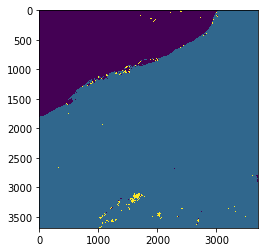

In [9]:
# La imagen resultado no tiene sistema de coordenadas
plt.imshow(clasified)

## Agregar Sistema de Coordenadas a la Imágen Clasificada

Dado de la imágen que resulta de al clasificación es un arreglo **np.array** de dos dimensiones, no contiene
los datos de localización de la imágen que permitirá su ubicación en el mapa. usarémos los datos de localización que se obtuvieron al principio del notebook cuando se carga el archivo .tif.

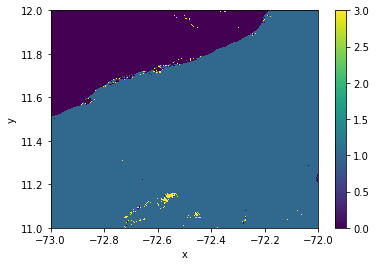

In [10]:
# Define las coordenadas de los puntos
coords = {'x':data_array['blue'].x.values,'y':data_array['blue'].y.values}

# Define el orden de las dimensiones
dims = ('y','x')

# Define los metadatos o atributos
attrs = {
    'crs': data_array['blue'].crs,
    'transform': data_array['blue'].transform
}

data_array_nn = xr.DataArray(data=clasified,coords=coords,dims=dims)
data_array_nn.plot()

In [11]:
# data_array.plot.save()
plt.imsave('nn_1.png', data_array_nn)

In [12]:
west = min(data_array_nn.x.values) 
east = max(data_array_nn.x.values)
south = min(data_array_nn.y.values) 
north = max(data_array_nn.y.values) 
(west,east,south,north)

(-73.0000331225, -71.9999716425, 11.000075240999998, 12.000094413)

# Clasificación con Naive Bayes


* Clase 0 (wofs): Agua
* Clase 1 (bosque): Bosque
* Clase 2 (wofs_bosque): Agua o Bosque
* Clase 3 (ninguno): Ninguna de las coverturas anteriores. Puedes ser repreentar una urbanización.

In [13]:
nb_model_path = './model_nb_multinomial.joblib'
nb_model = joblib.load(nb_model_path)

In [14]:
nb_model.predict([[4415.0,4694.0,4728.0,4888.0,4886.0,4312.0]])

array(['ninguno'], dtype='<U11')

In [15]:
def compute_nb(array):
    probabilities = []
    for i in range(0,array.shape[0]):
        probabilities.append(nb_model.predict(array[i]))
    
    result = np.array(probabilities)
    # Axis = 2 es la dimesnion que contiene las probabilidad des 
    # de las predicciones realizadas sobre las bandas espectrales
    result = np.transpose(result)
    return result

%time clasified_nb = compute_nb(inv)

CPU times: user 2.38 s, sys: 276 ms, total: 2.65 s
Wall time: 2.65 s


In [16]:
clasified_nb

array([['wofs', 'wofs', 'wofs', ..., 'ninguno', 'ninguno', 'ninguno'],
       ['wofs', 'wofs', 'wofs', ..., 'ninguno', 'ninguno', 'ninguno'],
       ['wofs', 'wofs', 'wofs', ..., 'ninguno', 'ninguno', 'ninguno'],
       ...,
       ['bosque', 'bosque', 'bosque', ..., 'bosque', 'bosque', 'ninguno'],
       ['bosque', 'bosque', 'bosque', ..., 'ninguno', 'bosque',
        'ninguno'],
       ['bosque', 'bosque', 'bosque', ..., 'ninguno', 'ninguno',
        'ninguno']], dtype='<U11')

## Reemplazo de Etiquetas por Números

In [17]:
# El número corresponde con el orden en las columnas de las etiquetas 
# para el conjuto de entrenamiento

clases = { 
    'wofs': 0,
    'bosque': 1,
    'wofs_bosque': 2,
    'ninguno':3
}

for k,v in clases.items():
    clasified_nb[clasified_nb == k] = v

In [18]:
clasified_nb = clasified_nb.astype(int)
clasified_nb

array([[0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3],
       ...,
       [1, 1, 1, ..., 1, 1, 3],
       [1, 1, 1, ..., 3, 1, 3],
       [1, 1, 1, ..., 3, 3, 3]])

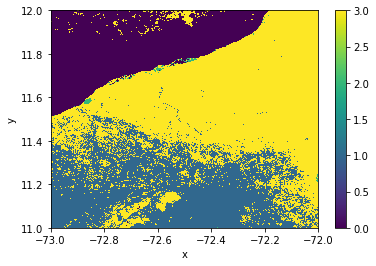

In [19]:
# Define las coordenadas de los puntos
coords = {'x':data_array['blue'].x.values,'y':data_array['blue'].y.values}

# Define el orden de las dimensiones
dims = ('y','x')

# Define los metadatos o atributos
attrs = {
    'crs': data_array['blue'].crs,
    'transform': data_array['blue'].transform
}

data_array_nb = xr.DataArray(data=clasified_nb,coords=coords,dims=dims)
data_array_nb.plot()

In [20]:
plt.imsave('example_naive_bayes.png', data_array_nb)